In [227]:
%pip install qiskit


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [228]:
%pip install qiskit-ibmq-provider

import numpy as np


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [229]:
from qiskit import IBMQ
# from qiskit_ibm_provider import IBMProvider

IBMQ.save_account('6c6a7f242a6e15d4ff69f3b5ddb95efada40b2a822012af5516515ecab99ef9458f4fe1bc7cafcdd199da533de1103350d5202d5acde3c2a83268fbf41171dbf', overwrite=True)
# IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_brisbane')

backend_defaults = backend.defaults()

In [230]:
backend_config = backend.configuration()
dt = backend_config.dt

In [231]:
backend.configuration().timing_constraints

{'acquire_alignment': 8,
 'granularity': 8,
 'min_length': 16,
 'pulse_alignment': 8}

In [232]:
import math

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
lcm = math.lcm(acquire_alignment, pulse_alignment)



1. Energy splitting (transition frequency) between the |0> and |1> states of the qubit

In [233]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz,
                            frequency_max / GHz,
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.721862962832168 GHz.
The sweep will go from 4.701862962832169 GHz to 4.741862962832169 GHz in steps of 1.0 MHz.


In [234]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

In [235]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [236]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [237]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [238]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

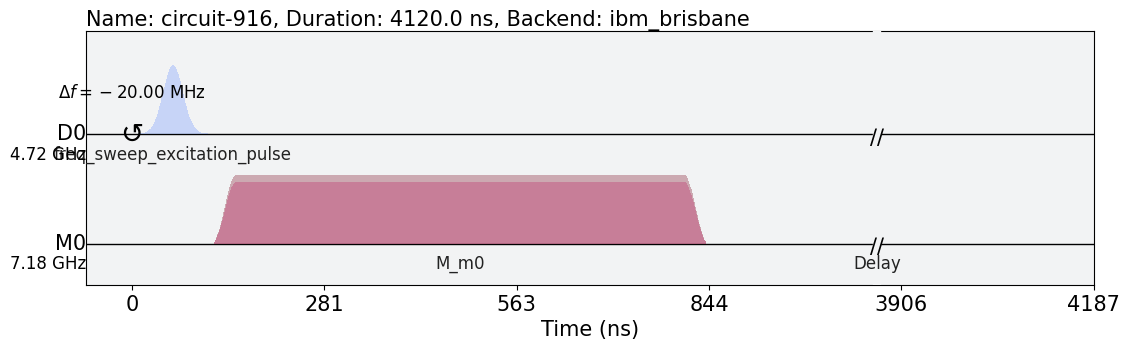

In [239]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [240]:
num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs,
                  meas_level=1,
                  meas_return='avg',
                  shots=num_shots_per_frequency)

IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api.quantum.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/65d0af3a718a110510c88c31/jobDataUploaded. Error in runtime client calling method runJob: Error executing POST https://runtime-us-east.quantum-computing.ibm.com/jobs {No request body}, Error code: 2413.'"

In [ ]:
# from qiskit.tools.monitor import job_monitor
# job_monitor(job)

In [206]:
frequency_sweep_results = backend.retrieve_job('cq55t107z1hg008kawtg').result(timeout=120) # timeout parameter set to 120 seconds

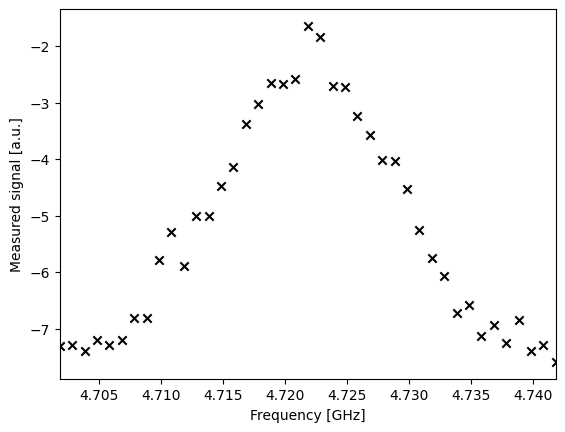

In [207]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), marker='x', color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [208]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, method='trf')
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit, conv

In [209]:
fit_params, y_fit, err = fit_function(frequencies_GHz,
                                 np.real(sweep_values),
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.721, 1, -2] # initial parameters for curve_fit
                                )


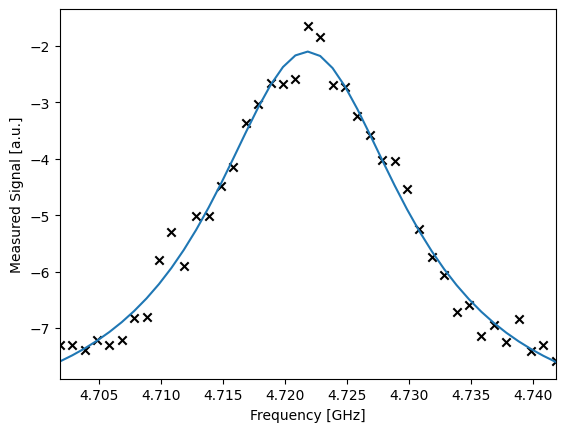

In [210]:
def qubit_freq(x, A, q_freq, B, C):
    return (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C

plt.scatter(frequencies_GHz, np.real(sweep_values), marker='x', color='black')

x_curve = np.arange(min(frequencies_GHz),max(frequencies_GHz), 0.0001)
plt.plot(frequencies_GHz, y_fit)
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [211]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz with uncertainty +/- {np.sqrt(err[1,1])}")

We've updated our qubit frequency estimate from 4.72186 GHz to 4.72183 GHz with uncertainty +/- 0.00014636156526024642


2. Drive strength necessary to realize a π – pulse (transferring all population from |0> to| 1>), and π/2 pulse

In [212]:
# This experiment uses these values from the previous experiment:

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [213]:
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

# drive_sigma_sec = 0.015 * us
# drive_duration_sec = drive_sigma_sec * 8

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [214]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

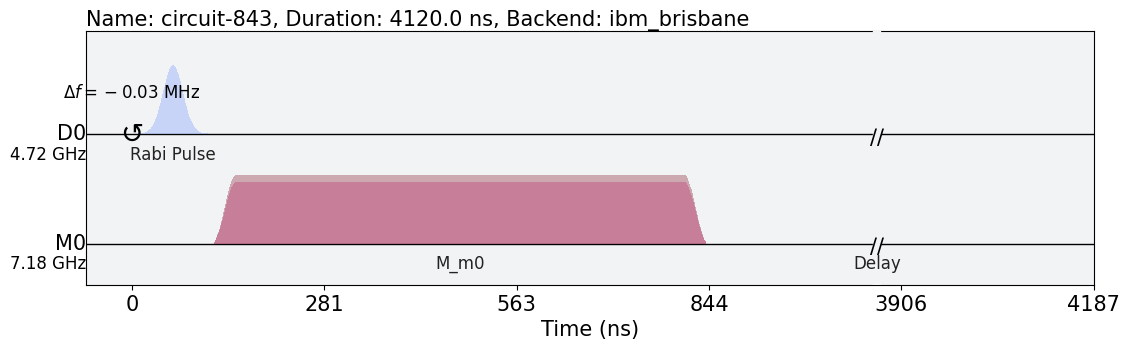

In [215]:
from qiskit import schedule
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [216]:
from qiskit.tools.monitor import job_monitor
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs,
                  meas_level=1,
                  meas_return='avg',
                  shots=num_shots_per_point)



In [217]:
%pip install qiskit_ibm_runtime


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [218]:
from qiskit_ibm_runtime import QiskitRuntimeService


rabi_results = backend.retrieve_job('cq56fjydhsd0008kh160').result(timeout=120)

In [219]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

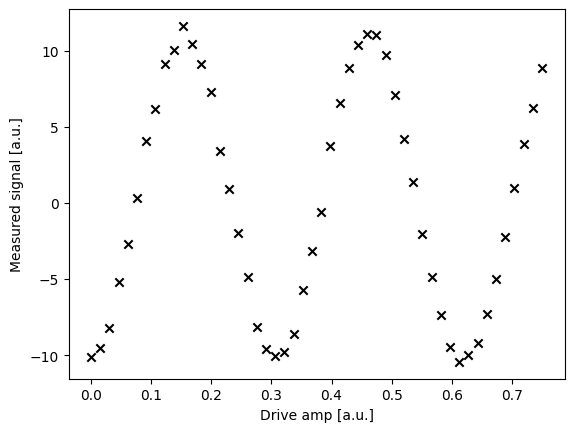

In [220]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, marker='x', color='black') # plot real part of Rabi values
plt.show()

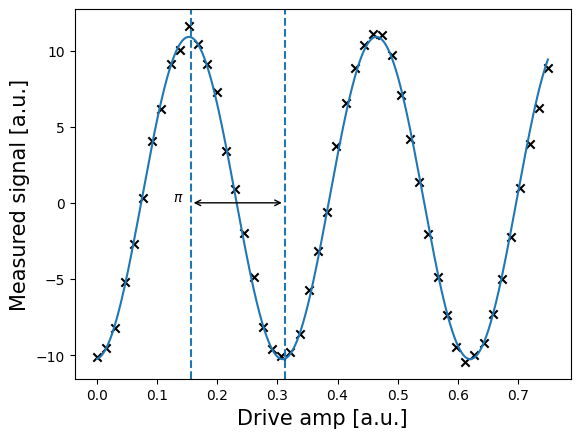

In [221]:
def rabi_osc(x, A, B, drive_period, phi):
    return A*np.cos(2*np.pi*x/drive_period - phi) + B

fit, err = curve_fit(rabi_osc, drive_amps, rabi_values, p0 = (10, 0, 0.3, 10), method = 'trf')

x_curve = np.arange(min(drive_amps),max(drive_amps),0.0001)
plt.scatter(drive_amps, rabi_values, marker='x', color='black')
plt.plot(x_curve, rabi_osc(x_curve, *fit))

drive_period = fit[2] # get period of rabi oscillation

plt.axvline(drive_period/2, linestyle='--')
plt.axvline(drive_period, linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->"))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1))

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [222]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp} with uncertainty +/- {abs(np.sqrt(err[2,2])/2)}")

Pi Amplitude = 0.15595885286996022 with uncertainty +/- 0.0003211357596759322


In [223]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

3. The qubit longitudinal relaxation time, T1. [Hint: it’s around 100 μs]

In [224]:
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [225]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

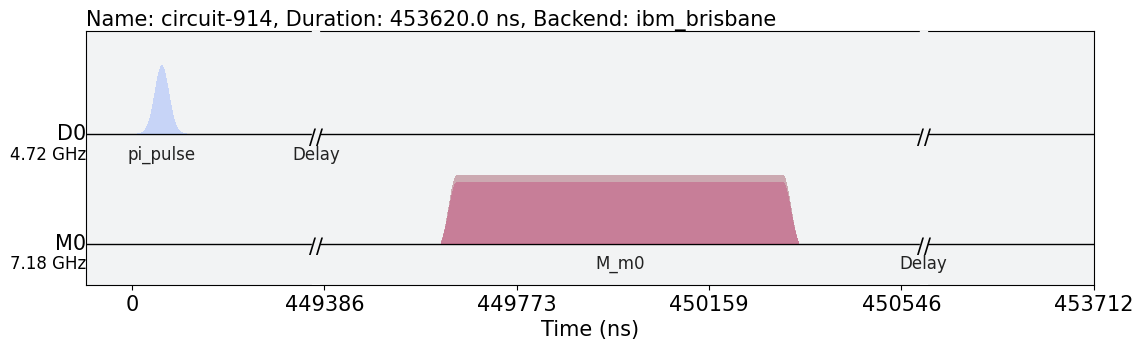

In [226]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [324]:
# Execution settings
num_shots = 256

job = backend.run(exp_t1_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots)

# job_monitor(job)

Job Status: job has successfully run


In [404]:
t1_results =  backend.retrieve_job('cq59s5wd7we0008vrnvg').result(timeout=120)

In [389]:
from qiskit.tools.monitor import job_monitor

qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

num_shots = 1024

# job = backend.run([qc_gnd, qc_exc], 
#                   meas_level=1, 
#                   meas_return='single', 
#                   shots=num_shots)


Job Status: job is queued (None)

IBMQJobApiError: "'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/cq9t79xf1wdg008ctsc0/status/v/1. Error in runtime client calling method getJob: Error executing GET https://runtime-us-east.quantum-computing.ibm.com/jobs/cq9t79xf1wdg008ctsc0 {No request body}, Error code: 2413.'"

/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_1235/3028404461.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(gnd_results), np.imag(gnd_results),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_1235/3028404461.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(exc_results), np.imag(exc_results),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_1235/3028404461.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_gnd), np.imag(mean_gnd),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_1235/3028404461.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_exc), np.imag(mean_exc),


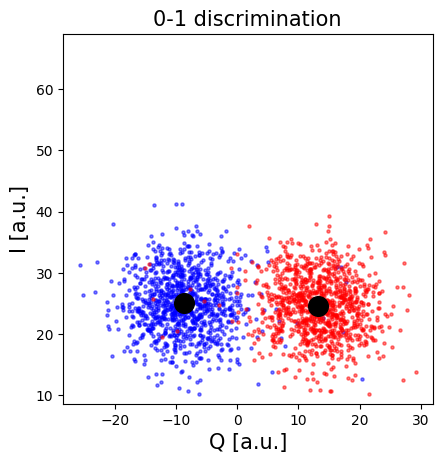

In [394]:
gnd_exc_results = job.result(timeout=120)
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()
mean_gnd = np.mean(gnd_results)

mean_exc = np.mean(exc_results)

In [391]:


def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

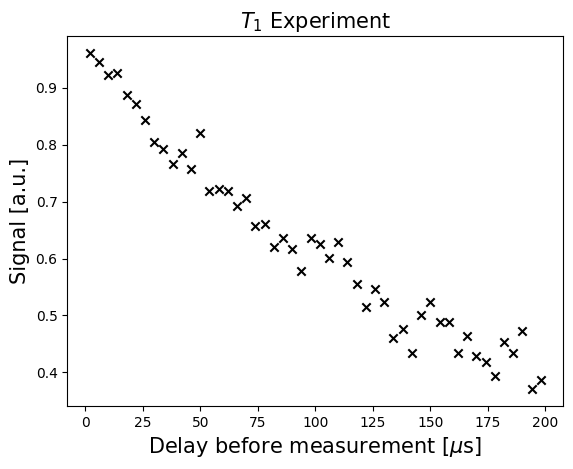

In [405]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / 256)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

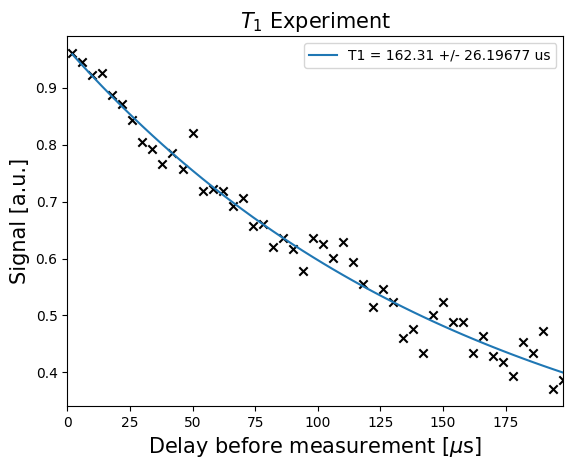

In [406]:
# Fit the data
fit_params, y_fit, err = fit_function(delay_times_sec/us, t1_values,
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} +/- {round(np.sqrt(err[2,2]),5)} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

4. The transverse relaxation time measured with a Ramsey experiment, T2*

In [440]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2
# print(drive_amp)

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

0.07797942643498011


In [441]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6)

In [442]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [443]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

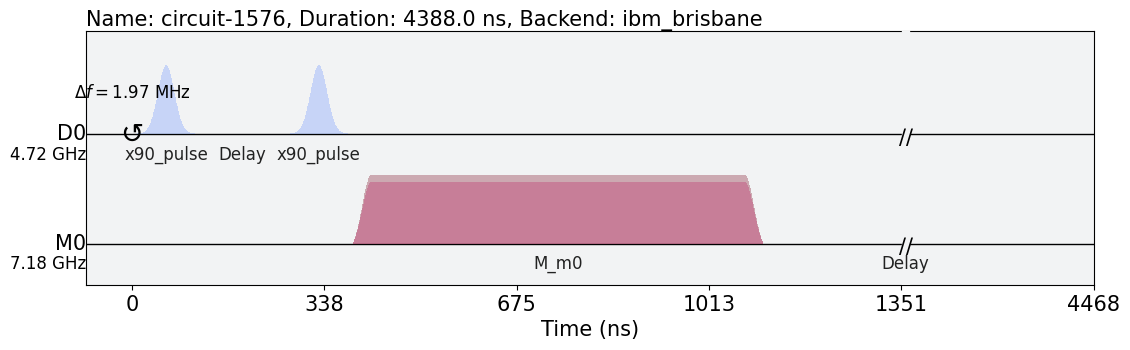

In [444]:
from qiskit import schedule
ramseyschedule = schedule(exp_ramsey_circs[2], backend)
ramseyschedule.draw(backend=backend)

In [445]:
# Execution settings
num_shots_per_point = 512

job = backend.run(exp_ramsey_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

# job_monitor(job)

In [446]:
ramsey_results = backend.retrieve_job('cq9tw30vxbdg008c4860').result(timeout=120)

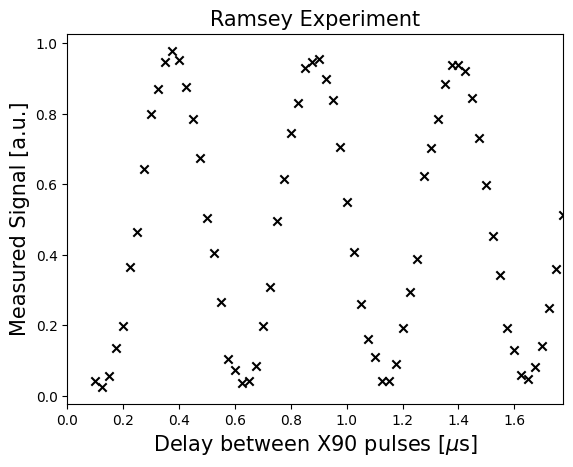

In [447]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / 512)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), marker='x', color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

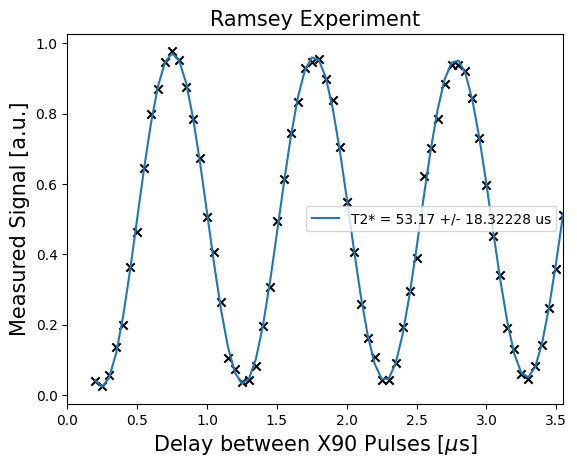

In [487]:
fit_params, y_fit, err = fit_function(2*delay_times_sec/us, ramsey_values,
             lambda x, A, B, del_f_MHz, C, ramsey: (A * np.exp(-x / ramsey)*np.cos(2*np.pi*del_f_MHz*x - C) + B),
             [1, 0, 100, 0, 100])

_, _, del_f_MHz, _, ramsey, = fit_params
print()

plt.scatter(2*delay_times_sec/us, ramsey_values, marker='x', color='black')
plt.plot(2*delay_times_sec/us, y_fit, label=f"T2* = {ramsey:.2f} +/- {round(np.sqrt(err[4,4]),5)} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 Pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [488]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.622843 GHz. It used to be 4.721829 GHz


5. The transverse relaxation time measured with a Hahn echo experiment, T2

In [489]:
# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

# We will use the pi_pulse and x90_pulse from previous experiments

In [490]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [491]:
t2_gate = Gate("t2", 1, [delay])

qc_t2 = QuantumCircuit(1, 1)

qc_t2.append(t2_gate, [0])
qc_t2.measure(0, 0)
qc_t2.add_calibration(t2_gate, (0,), t2_schedule, [delay])

exp_t2_circs = [qc_t2.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

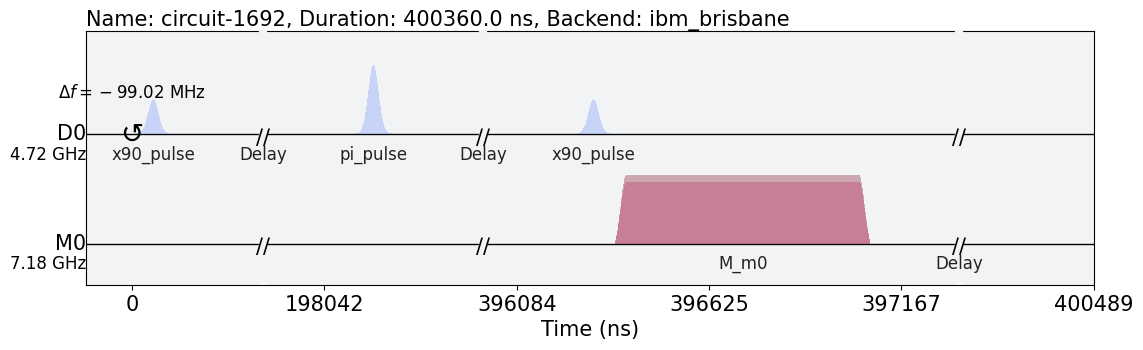

In [492]:
t2_schedule = schedule(exp_t2_circs[-1], backend)
t2_schedule.draw(backend=backend)

In [493]:
# Execution settings
num_shots_per_point = 512

job = backend.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

# job_monitor(job)

In [495]:
t2_results = backend.retrieve_job('cq9vy5rcc620008m4ja0').result(timeout=120)

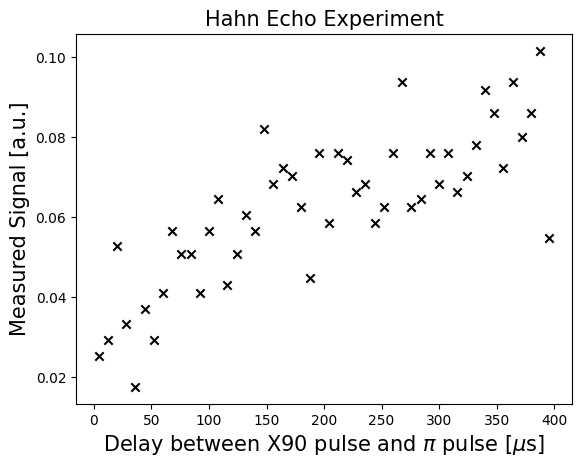

In [496]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(2*delay_times_sec/us, t2_values, marker='x', color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

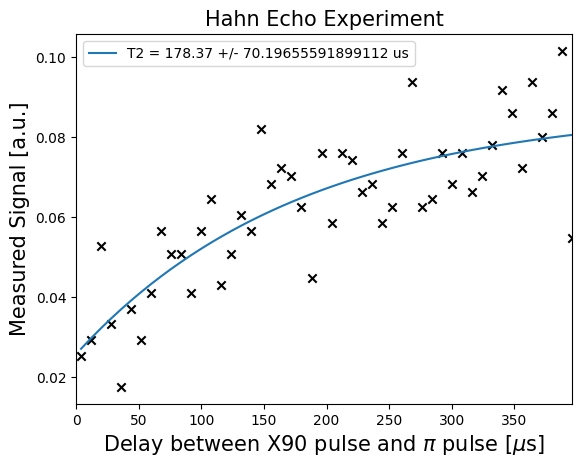

In [497]:
fit_params, y_fit, err = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*delay_times_sec/us, t2_values, marker='x', color='black')
plt.plot(2*delay_times_sec/us, y_fit, label=f"T2 = {T2:.2f} +/- {np.sqrt(err[2,2])} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

6. The energy splitting between the |1> and |2> states of the qubit

First find the |0> to |1> transition frequency. Then to calibrate the X-180 pulse amplitude, before using this amplitude and the aforementioned frequency to then find the |1> to |2> transition frequency.

In [267]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

backend_properties = backend.properties()
qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz.
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.721862962832168 GHz.
Default anharmonicity is -0.31197865973435573 GHz.


In [269]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results =  job.result()# timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [270]:
x12_duration = 160
x12_sigma = 40
num_freqs = 75
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [273]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [274]:
spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(1, 1)

qc_spect.x(0)
qc_spect.append(spect_gate, [0])
qc_spect.measure(0, 0)
qc_spect.add_calibration(spect_gate, (0,), freq12_sweep_sched, [freq])

exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

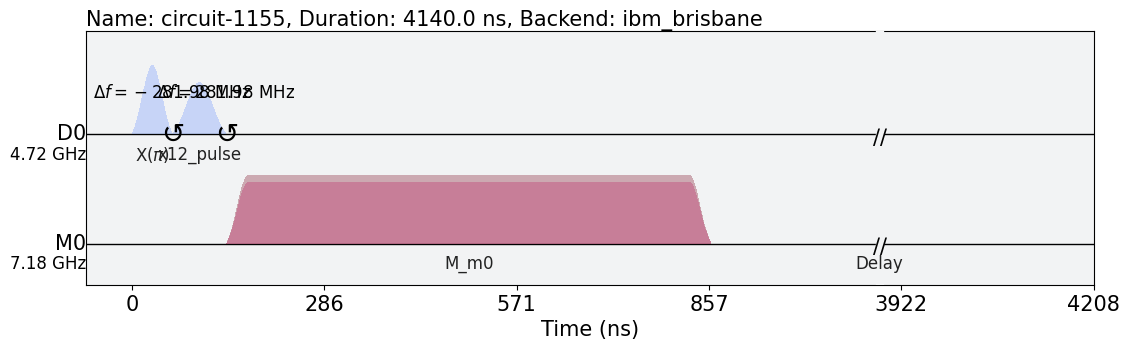

In [371]:
from qiskit import schedule
schedule = schedule(exp_spect_circs[-1], backend)
schedule.draw(backend=backend)

In [243]:
excited_freq_sweep_job = backend.run(exp_spect_circs,
                                     meas_level=1,
                                     meas_return='avg',
                                     shots=NUM_SHOTS)

In [244]:
job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [276]:
excited_freq_sweep_data = get_job_data(backend.retrieve_job('cq5tdh6hbttg008r7aa0').result(timeout=120), average=True)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [278]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit, conv

In [279]:
(excited_sweep_fit_params,
 excited_sweep_y_fit, err) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data,
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.425*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

The transition frequency from |1> to |2> is  4.4098 +/- 2.978e-07


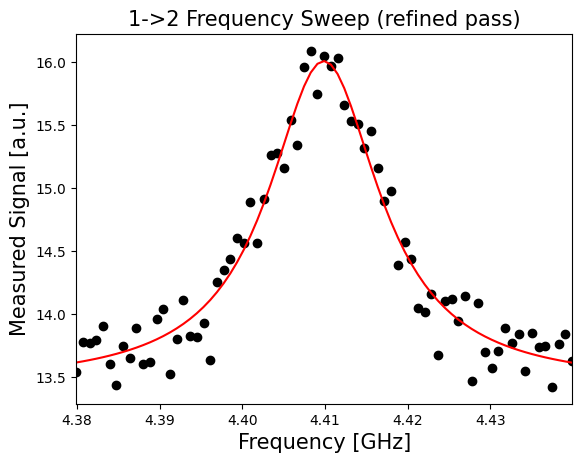

In [498]:
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
print("The transition frequency from |1> to |2> is  %.4f +/- %.3e" %(excited_sweep_fit_params[1]/GHz, np.sqrt(err[1,1]/GHz)))
plt.show()

7. Optional: can you improve the readout fidelity of 0/1 by putting the |1> population into |2>?